# Car Price Prediction with PySpark
## data-info: Used cars in United States for sale
## data-source: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 

# 1. Installation

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=ba85c0bf23732c6ed21af71406d5b311abaaff7991c763dc6ba26f773ef92e84
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


# 2. Import Necessary Modules

In [2]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions as F

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# 3. Create a Spark Session

In [3]:
spark = SparkSession.builder.appName('Tutorial').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/12 11:27:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 4. Let's read the file

In [4]:
file_path = '../input/craigslist-carstrucks-data/vehicles.csv'

df_cars = spark.read.options(header=True, inferSchema=True, delimiter=',', multiLine=True).csv(file_path)

# 5. Let's print the schema

In [5]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null

# 6. Data Cleaning

* "url", "region_url", "image_url", "description" columns are unnecessary. let's drop them
* It seems pyspark interpreted "lat" and "long" columns as string
* We should clean these columns from alphabetic characters
* And we should check the numeric range of "lat" and "long" columns
* Some categorical columns have own null indicators like "other", set them null

In [6]:
# these columns are useless to us, drop them

drop_cols = ['url', 'region_url', 'image_url', 'description']

df_cars = df_cars.drop(*drop_cols)

In [7]:
# both null values and null indicators(other) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('other', None, subset=['cylinders'])

In [8]:
# both null values and null indicators(missing) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('missing', None, subset=['title_status'])

In [9]:
# Latitude should be between (-90, 90), otherwise set null

df_cars = df_cars.withColumn('lat', F.when(F.col('lat').rlike('^-?\d+\.?\d+$'), F.col('lat')))
df_cars = df_cars.withColumn('lat', F.col('lat').cast(types.FloatType()))
df_cars = df_cars.withColumn('lat', F.when((-90 <= F.col('lat')) & (F.col('lat') <= 90), F.col('lat')))

In [10]:
# Longitude should be between (-180, 180), otherwise set null

df_cars = df_cars.withColumn('long', F.when(F.col('long').rlike('^-?\d+\.?\d+$'), F.col('long')))
df_cars = df_cars.withColumn('long', F.col('long').cast(types.FloatType()))
df_cars = df_cars.withColumn('long', F.when((-180 <= F.col('long')) & (F.col('long') <= 180), F.col('long')))

In [11]:
# Posting date should be in format yyyy-MM-dd HH:mm:ss.SSSS

df_cars = df_cars.withColumn('posting_date', F.when(F.col('posting_date').rlike('^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'), F.col('posting_date')))
df_cars = df_cars.withColumn('posting_date', F.col('posting_date').cast(types.TimestampType()))

# 7. Descriptive Statistics
## Hint: If data is too big you can sample it before the descriptive stat calculations

In [12]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+
|summary|              price|              year|          odometer|              lat|              long|
+-------+-------------------+------------------+------------------+-----------------+------------------+
|  count|             426582|            425377|            422182|           365481|            367830|
|   mean|  75240.00097753773|2011.2356544900172|  98019.2444514451|38.27485954294108|-92.92308876290198|
| stddev|1.218653645968038E7|   9.4529441236719|213407.41232087038|5.757416442913367| 20.91019012781645|
|    min|                  0|              1900|                 0|       -84.122246|        -159.82773|
|    25%|               5900|              2008|             37675|          34.4329|           -106.62|
|    50%|              13950|              2013|             85519|          39.0278|        -87.322266|
|    75%|              26455|              2017|       

# 8. Data Wrangling
* "price" and "odometer" columns have right skewed distribution (mean is bigger than median)
* "price" and "odometer" columns have too big numbers and too much standard deviation, we can take the log of them
* "posting_date" column can be split to "posting_year", "posting_month"

In [13]:
# both columns starts with 0, log(0) is undefined so we should put +1

df_cars = df_cars.withColumn('price', F.log10(F.col('price') + 1))
df_cars = df_cars.withColumn('odometer', F.log10(F.col('odometer') + 1))

In [14]:
# date column to year and month columns

df_cars = df_cars.withColumn('posting_year', F.year(F.col('posting_date')))
df_cars = df_cars.withColumn('posting_month', F.month(F.col('posting_date')))

df_cars = df_cars.drop('posting_date')

In [15]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|             price|              year|          odometer|              lat|              long|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|            426582|            425377|            422182|           365481|            367830|
|   mean|3.7736931253525903|2011.2356544900172| 4.745384684351896|38.27485954294108|-92.92308876290198|
| stddev|1.2051273580604176|   9.4529441236719|0.7163314827973487|5.757416442913367| 20.91019012781645|
|    min|               0.0|              1900|               0.0|       -84.122246|        -159.82773|
|    25%|3.7709256146389993|              2008| 4.576064788225377|          34.4329|           -106.62|
|    50%| 4.144605338714745|              2013| 4.932067692200722|          39.0278|        -87.322266|
|    75%| 4.422524181905646|              2017|5.125608119717532

# 9. Data Visualization

In [16]:
df_cars.createOrReplaceTempView('cardata')

22/08/12 11:28:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## 9.1. Histogram

In [17]:
df_result = spark.sql('SELECT manufacturer, price FROM cardata WHERE manufacturer IN ("chevrolet", "ford", "toyota")')
df_result = df_result.toPandas()

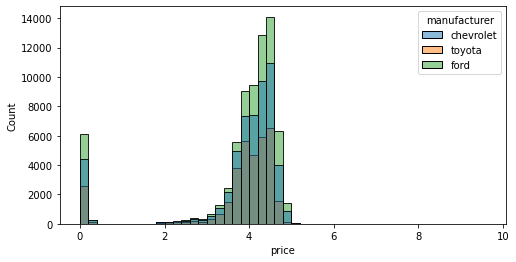

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.histplot(data=df_result, x='price', hue='manufacturer', binwidth=0.2, ax=ax)

plt.show()

## 9.2. Scatter Plot

In [19]:
df_result = spark.sql('SELECT condition, odometer, price FROM cardata')
df_result = df_result.toPandas()

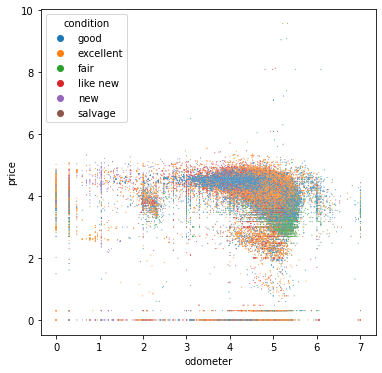

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

_ = sns.scatterplot(data=df_result, x='odometer', y='price', hue='condition', ax=ax, s=1)

plt.show()

## 9.3. Pie Chart

In [21]:
df_result = spark.sql('SELECT condition FROM cardata')
df_result = df_result.toPandas()

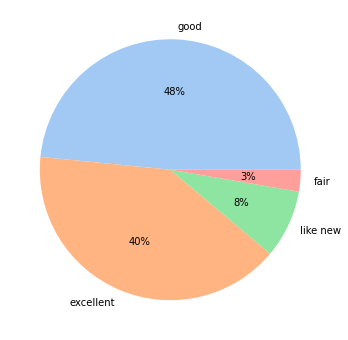

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

data = df_result['condition'].value_counts().nlargest(4)
colors = sns.color_palette('pastel')

plt.pie(data.values, labels=data.index, colors=colors, autopct='%.0f%%')
plt.show()

# 10. Category Dropping
## * Some columns have too much categories, let's drop infrequent ones

In [23]:
num_cols = ['year', 'odometer', 'lat', 'long', 'posting_year', 'posting_month']

cat_cols = ['region', 'manufacturer', 'model', 'condition', \
            'cylinders', 'fuel', 'title_status', 'transmission',\
           'VIN', 'drive', 'size', 'type', 'paint_color', 'county', 'state']

In [24]:
n = 32

for col in cat_cols:
    most_freq = df_cars.groupBy(col).count().orderBy('count', ascending=False).take(n - 1)
    most_freq = spark.createDataFrame(most_freq).toPandas()
    most_freq = most_freq[col].tolist()

    df_cars = df_cars.withColumn(col, F.when(F.col(col).isin(most_freq), F.col(col)))

# 11. Imputation

## 11.1. On Numeric Columns

In [25]:
imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(df_cars)
df_cars = model.transform(df_cars)

## 11.2. On Categorical Columns

In [26]:
df_cars = df_cars.fillna('unknown', subset=cat_cols)

# 12. Categorical Column Encoding

In [27]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    df_cars = indexer.fit(df_cars).transform(df_cars)
    
df_cars = df_cars.drop(*cat_cols)

# 13. Training

In [28]:
cols = df_cars.columns
cols.remove('id')
cols.remove('price')

assembler = VectorAssembler(inputCols=cols, outputCol='features')

df_cars = assembler.transform(df_cars)

In [29]:
df_data = df_cars.select(F.col('features'), F.col('price').alias('label'))
df_train, df_test = df_data.randomSplit([0.8, 0.2])

In [30]:
classifier = RandomForestRegressor(featuresCol='features', labelCol='label')
evaluator = RegressionEvaluator()
grid = ParamGridBuilder().build()

In [31]:
cv = CrossValidator(estimator=classifier, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)

cv_model = cv.fit(df_train)

# 14. Evaluation

In [32]:
cv_model.avgMetrics

[1.1031136827866834]

In [33]:
df_test = cv_model.bestModel.transform(df_test)

In [34]:
df_test.show(5)

+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|(21,[0,1,2,3,4,5]...|3.6986224297020978|3.7348331053965125|
|(21,[0,1,2,3,4,5]...| 4.204147125212848|3.7348331053965125|
|(21,[0,1,2,3,4,5]...| 4.201424437579911|3.7348331053965125|
|(21,[0,1,2,3,4,5]...| 3.826139617935915|3.7348331053965125|
|(21,[0,1,2,3,4,5]...|4.2767144946302915|3.7348331053965125|
+--------------------+------------------+------------------+
only showing top 5 rows



In [35]:
RegressionEvaluator(predictionCol='prediction', labelCol='label').evaluate(df_test)

1.1114902579919188

# 15. Single Sample Prediction

In [36]:
X_test, y_test = df_test.head().features, df_test.head().label
y_pred = cv_model.bestModel.predict(X_test)

print(f'prediction: {y_pred}, ground truth: {y_test}')

prediction: 3.7348331053965125, ground truth: 3.6986224297020978
